# Imports & Configs

In [98]:
#uncomment the next line to download all the modules used in this project
#it only needs to run once per system used
#%pip install numpy pandas seaborn matplotlib optuna scikit-learn xgboost catboost lightgbm sklearn_relief deap

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
import sklearn_relief as sr
import deap
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_classification
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import os
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)



# Data Preprocessing & EDA

In [100]:
for dirname, _, filenames in os.walk('.\kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if 'Train' in filename:
            train=pd.read_csv(os.path.join(dirname, filename))
        if 'Test' in filename:
            test=pd.read_csv(os.path.join(dirname, filename))
train

.\kaggle\input\Amprion.csv
.\kaggle\input\Test_data.csv
.\kaggle\input\Train_data.csv


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [102]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [103]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


## Missing Data

In [105]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values

## Duplicates 

In [106]:
if train.duplicated().sum():
    print(f"Number of duplicate rows: {train.duplicated().sum()}")
    print(f"they will be removed")
    train.drop_duplicates(keep='first', inplace=True)
else:
    print(f"There are no duplicates within the dataset")

There are no duplicates within the dataset


## Outliers 

In [107]:
# for col in df:
#     if col != 'class' and is_numeric_dtype(df[col]):
#         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#         g1 = sns.boxplot(x = df[col], ax=ax[0])
#         g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
#         plt.show()

No outliers

<Axes: >

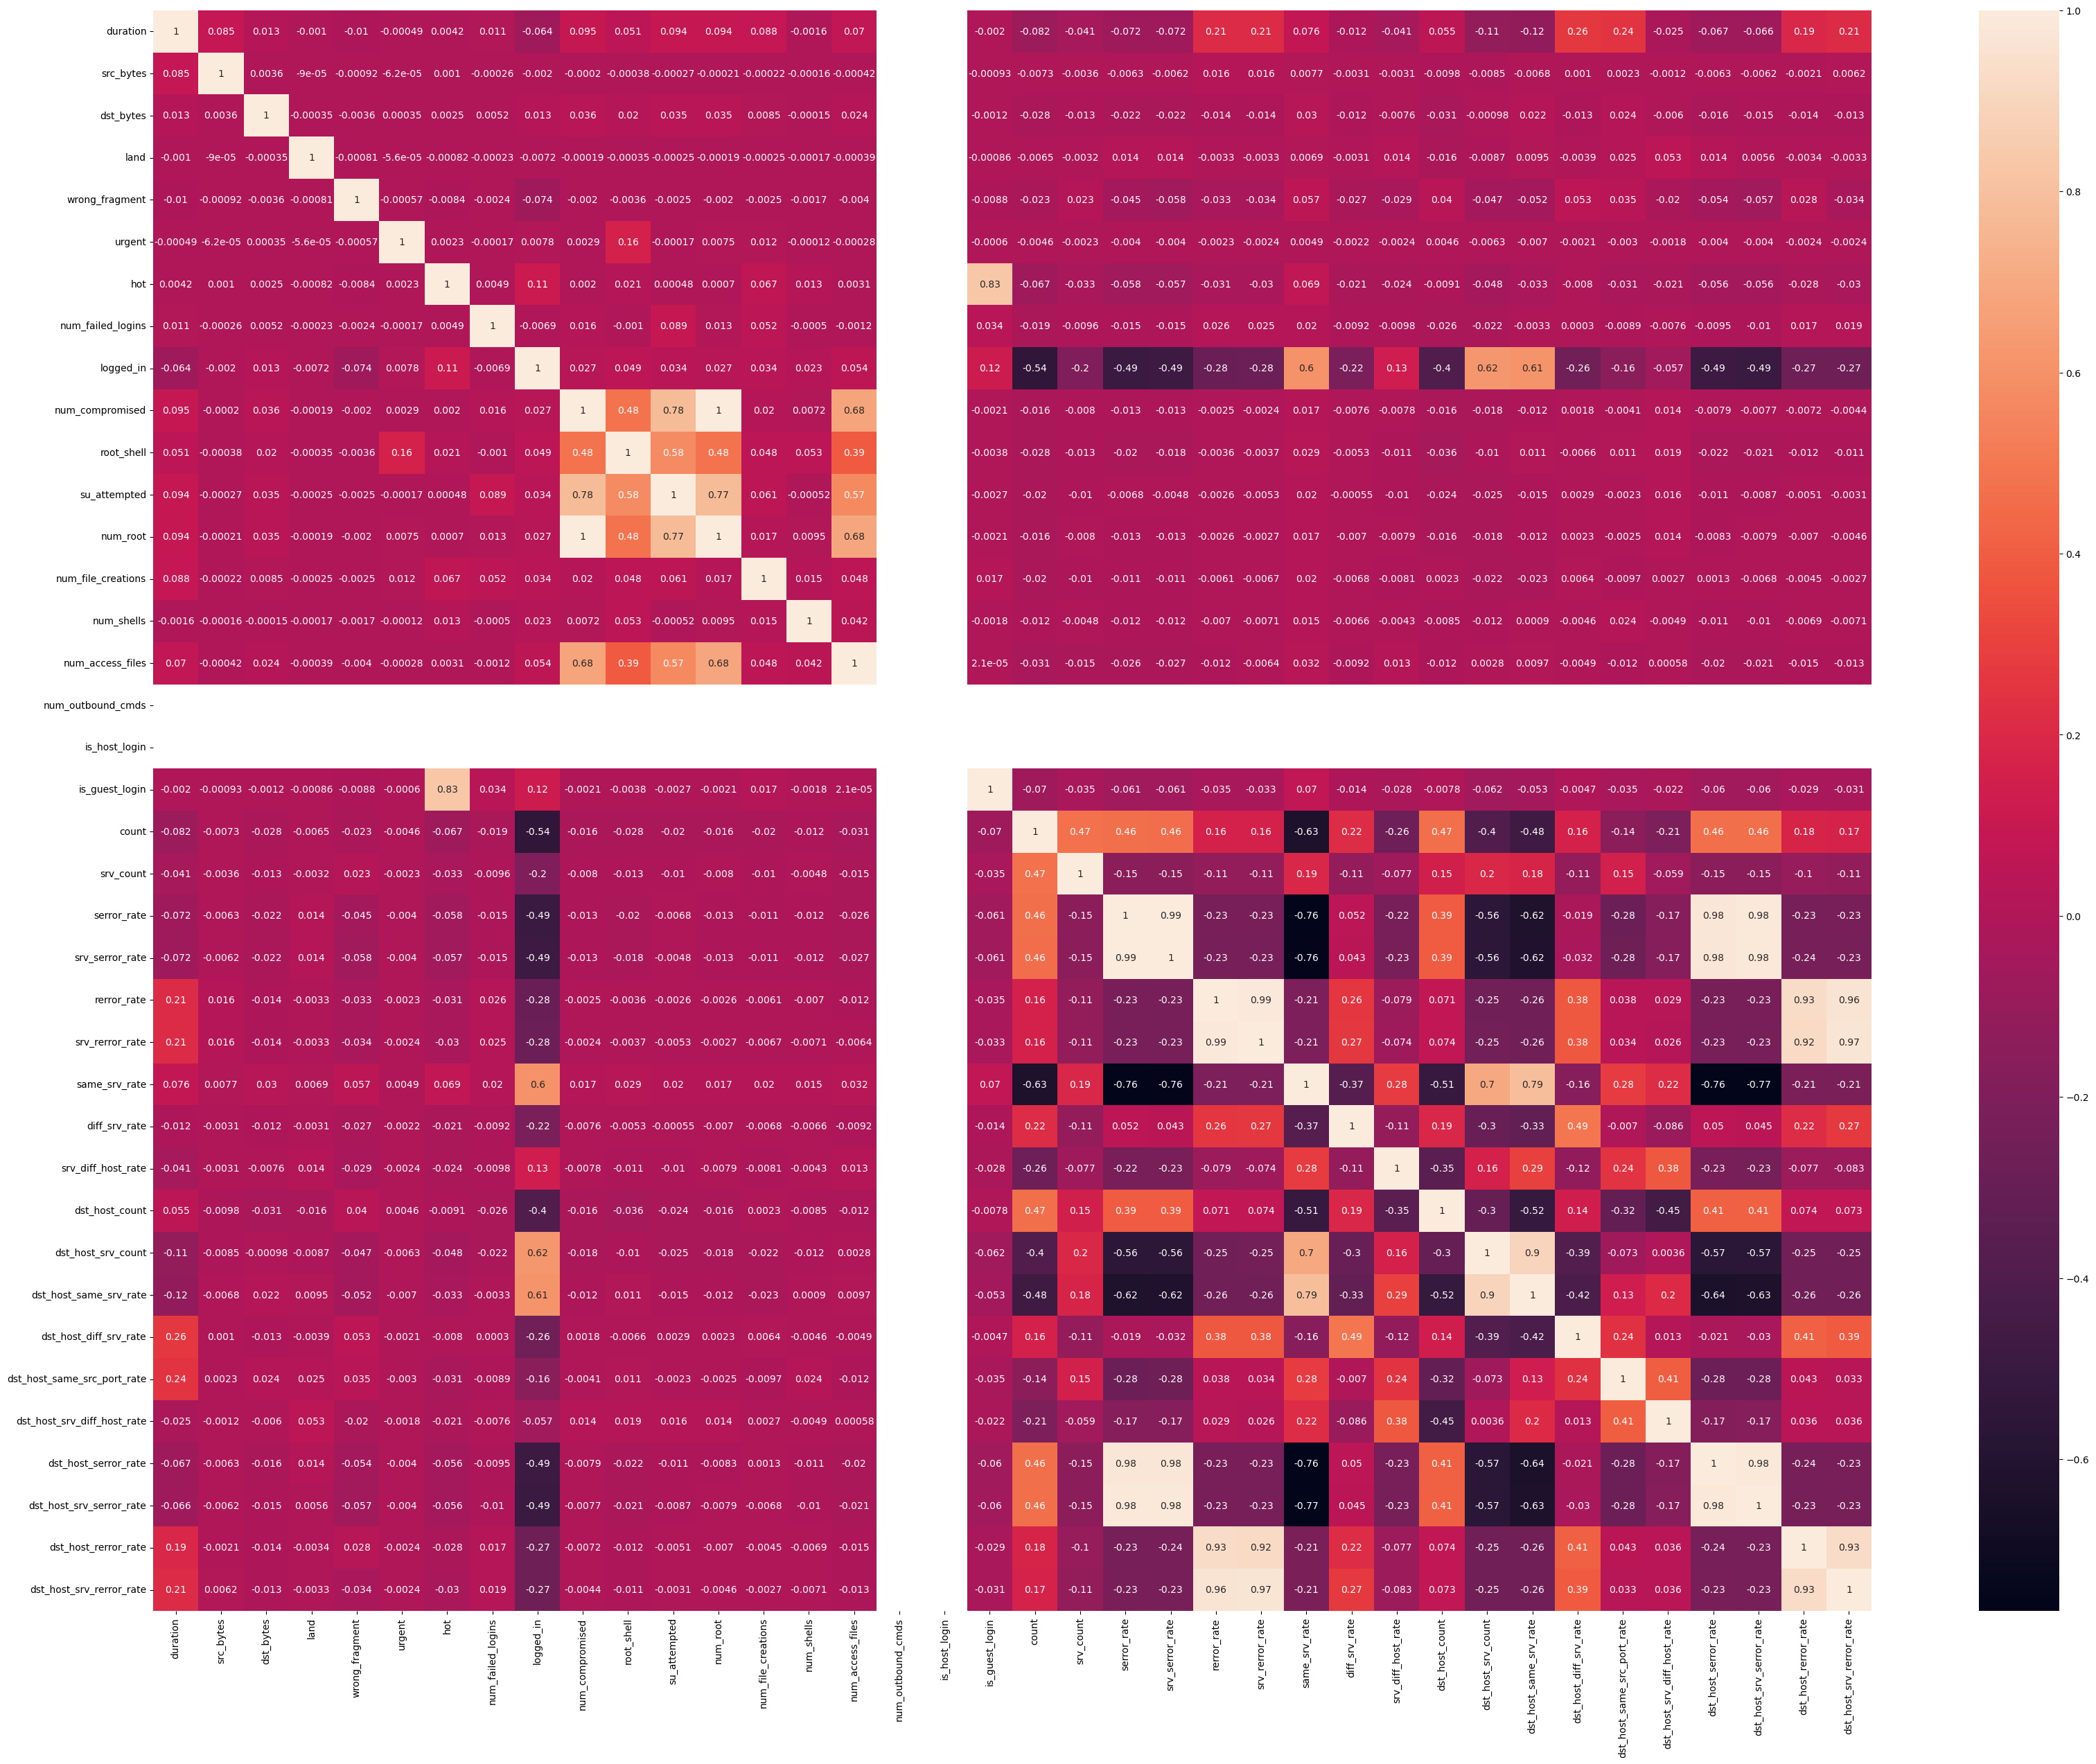

In [108]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(numeric_only=True), annot=True)

# import plotly.express as px
# fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
# fig.show()

<Axes: xlabel='class', ylabel='count'>

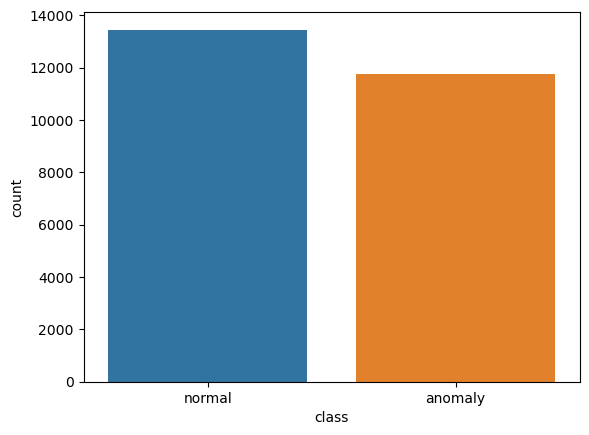

In [109]:
sns.countplot(x=train['class'])

# Label Encoding

In [110]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

# Removing Redundant column

In [111]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


# Random Forest Feature selection

In [112]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [113]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
rf_selected_features = [v for i, v in feature_map if i==True]

rf_selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [114]:
rf_X_train = X_train[rf_selected_features]

In [115]:
scale = StandardScaler()
rf_X_train = scale.fit_transform(rf_X_train)
rf_test = scale.fit_transform(test)

# RReliefF Feature Selection

In [116]:
r = sr.RReliefF(n_features = 10)
rrff_x_train = StandardScaler().fit_transform(X_train)
rrff_x_train = r.fit_transform(rrff_x_train, Y_train)
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [117]:
X_train = X_train[selected_features]

# Split and scale data

In [118]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)
rf_x_train, rf_x_test, rf_y_train, rf_y_test = train_test_split(rf_X_train, Y_train, train_size=0.70, random_state=2)

# K Nearest Neighbors (KNN) classification model

In [120]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [121]:
def rf_objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(rf_x_train, rf_y_train)
    accuracy = classifier_obj.score(rf_x_test, rf_y_test)
    return accuracy

In [122]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.9797565493516803], datetime_start=datetime.datetime(2023, 9, 11, 3, 11, 53, 365161), datetime_complete=datetime.datetime(2023, 9, 11, 3, 11, 55, 786972), params={'KNN_n_neighbors': 15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [123]:
rf_study_KNN = optuna.create_study(direction='maximize')
rf_study_KNN.optimize(rf_objective, n_trials=1)
print(rf_study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.9790949986768986], datetime_start=datetime.datetime(2023, 9, 11, 3, 11, 55, 805071), datetime_complete=datetime.datetime(2023, 9, 11, 3, 11, 57, 735394), params={'KNN_n_neighbors': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [124]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9807190654417602
Test Score: 0.9797565493516803


In [125]:
rf_KNN_model = KNeighborsClassifier(n_neighbors=rf_study_KNN.best_trial.params['KNN_n_neighbors'])
rf_KNN_model.fit(rf_x_train, rf_y_train)

rf_KNN_train, rf_KNN_test = rf_KNN_model.score(rf_x_train, rf_y_train), rf_KNN_model.score(rf_x_test, rf_y_test)

print(f"Train Score: {rf_KNN_train}")
print(f"Test Score: {rf_KNN_test}")

Train Score: 0.9798684359759555
Test Score: 0.9790949986768986


# Logistic Regression Model

In [126]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [127]:
rf_lg_model = LogisticRegression(random_state = 42)
rf_lg_model.fit(rf_x_train, rf_y_train)

LogisticRegression(random_state=42)

In [128]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9287739593966202
Test Score: 0.9231278115903678


In [129]:
rf_lg_train, rf_lg_test = rf_lg_model.score(rf_x_train , rf_y_train), rf_lg_model.score(rf_x_test , rf_y_test)

print(f"Training Score: {rf_lg_train}")
print(f"Test Score: {rf_lg_test}")

Training Score: 0.9287739593966202
Test Score: 0.9231278115903678


# Decision Tree Classifier

In [130]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [131]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=9, state=1, values=[0.9960306959513099], datetime_start=datetime.datetime(2023, 9, 11, 3, 12, 7, 372575), datetime_complete=datetime.datetime(2023, 9, 11, 3, 12, 7, 436546), params={'dt_max_depth': 12, 'dt_max_features': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=9, value=None)


In [132]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.998865827378927
Test Score: 0.9933844932521831


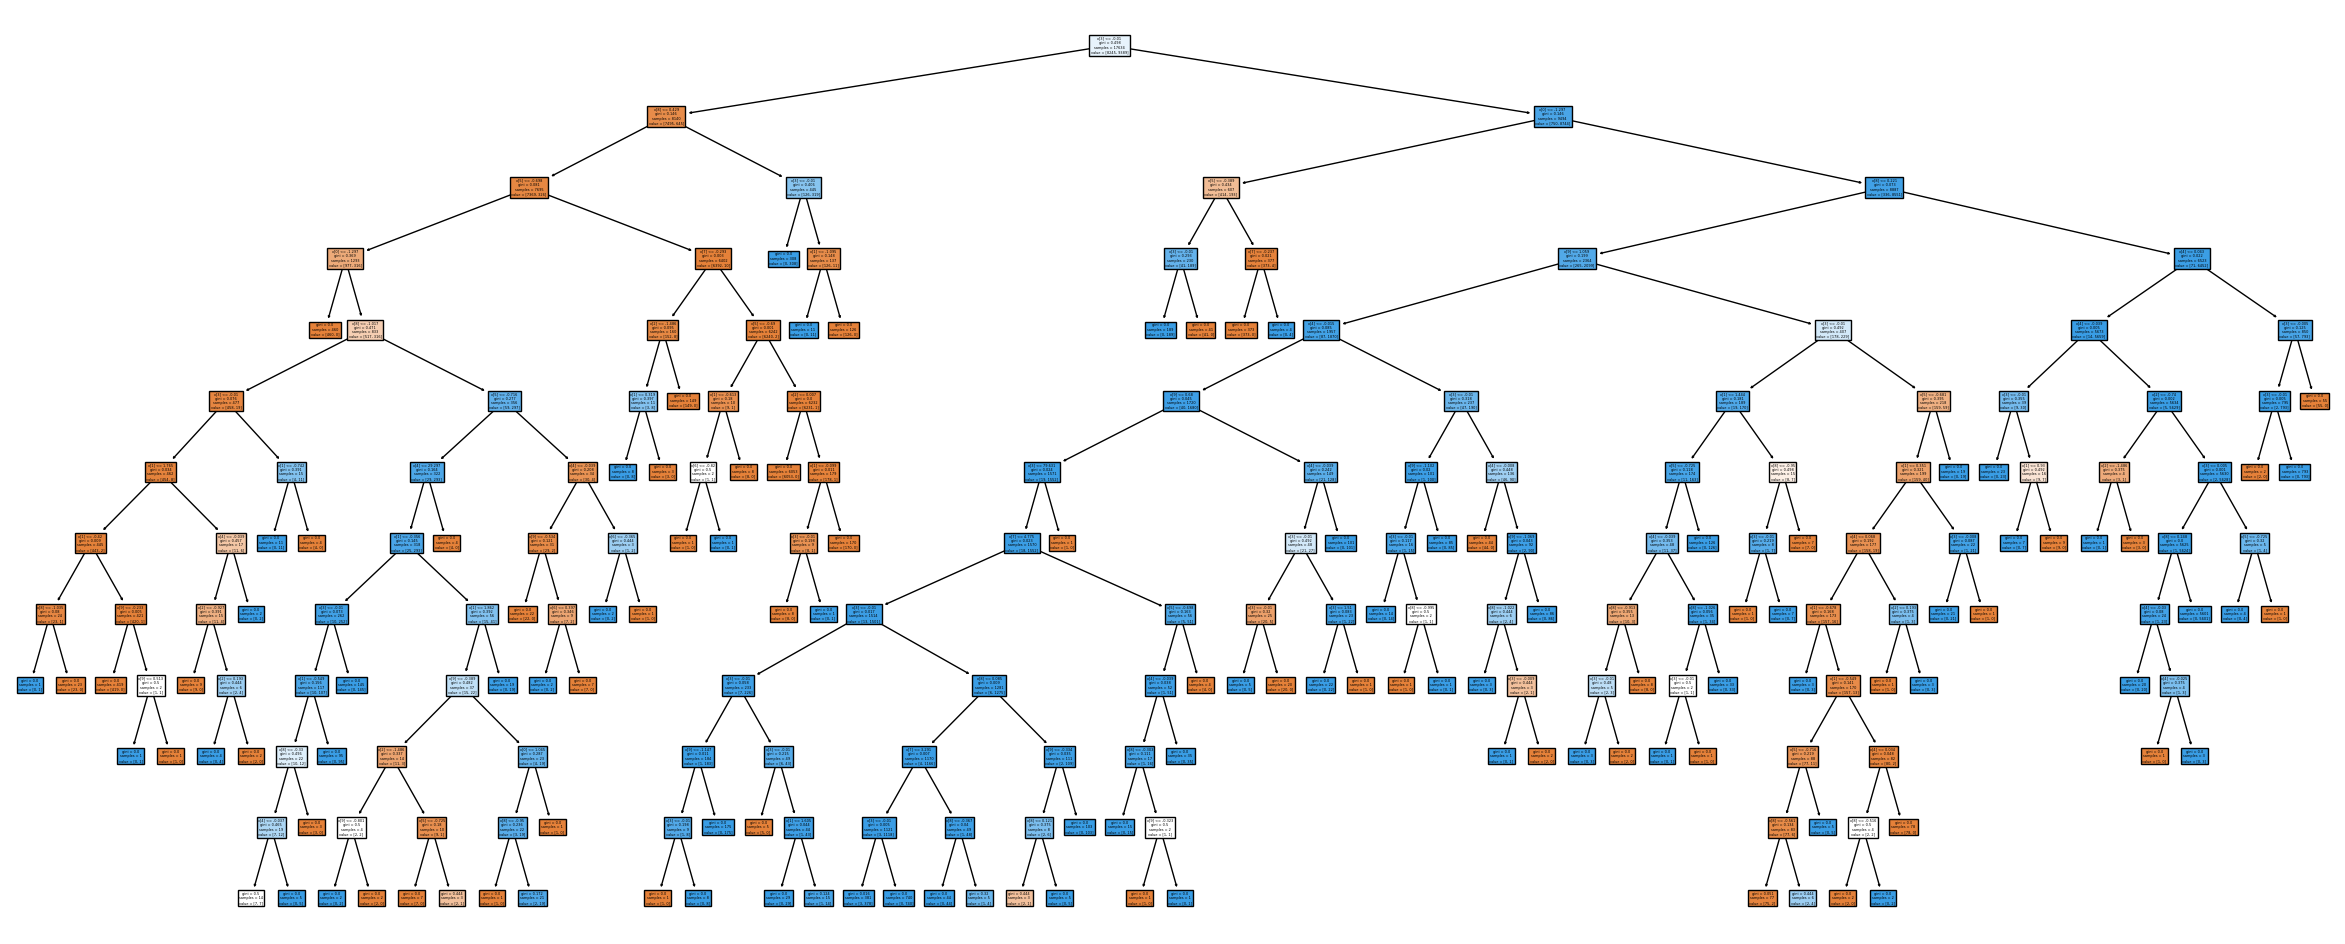

In [133]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

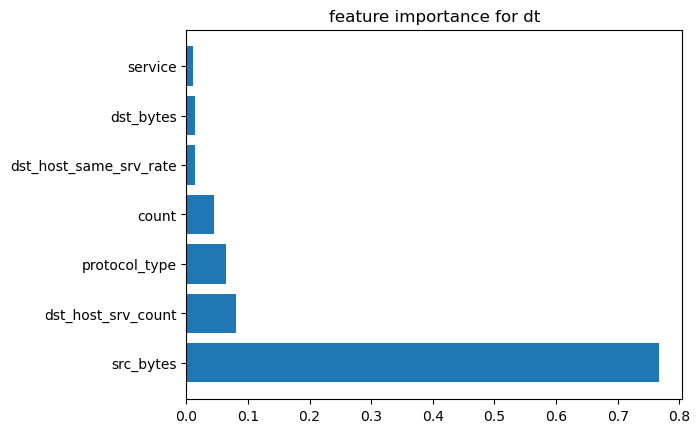

In [134]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importance(abs(dt.feature_importances_), features_names, top=7)

In [135]:
def rf_objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(rf_x_train, rf_y_train)
    accuracy = classifier_obj.score(rf_x_test, rf_y_test)
    return accuracy

In [136]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(rf_objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=25, state=1, values=[0.9960306959513099], datetime_start=datetime.datetime(2023, 9, 11, 3, 12, 22, 471982), datetime_complete=datetime.datetime(2023, 9, 11, 3, 12, 22, 533981), params={'dt_max_depth': 27, 'dt_max_features': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=25, value=None)


In [137]:
rf_dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
rf_dt.fit(rf_x_train, rf_y_train)

rf_dt_train, rf_dt_test = rf_dt.score(rf_x_train, rf_y_train), rf_dt.score(rf_x_test, rf_y_test)

print(f"Random Forest Train Score: {rf_dt_train}")
print(f"Random forest Test Score: {rf_dt_test}")

Random Forest Train Score: 1.0
Random forest Test Score: 0.9941783540619211


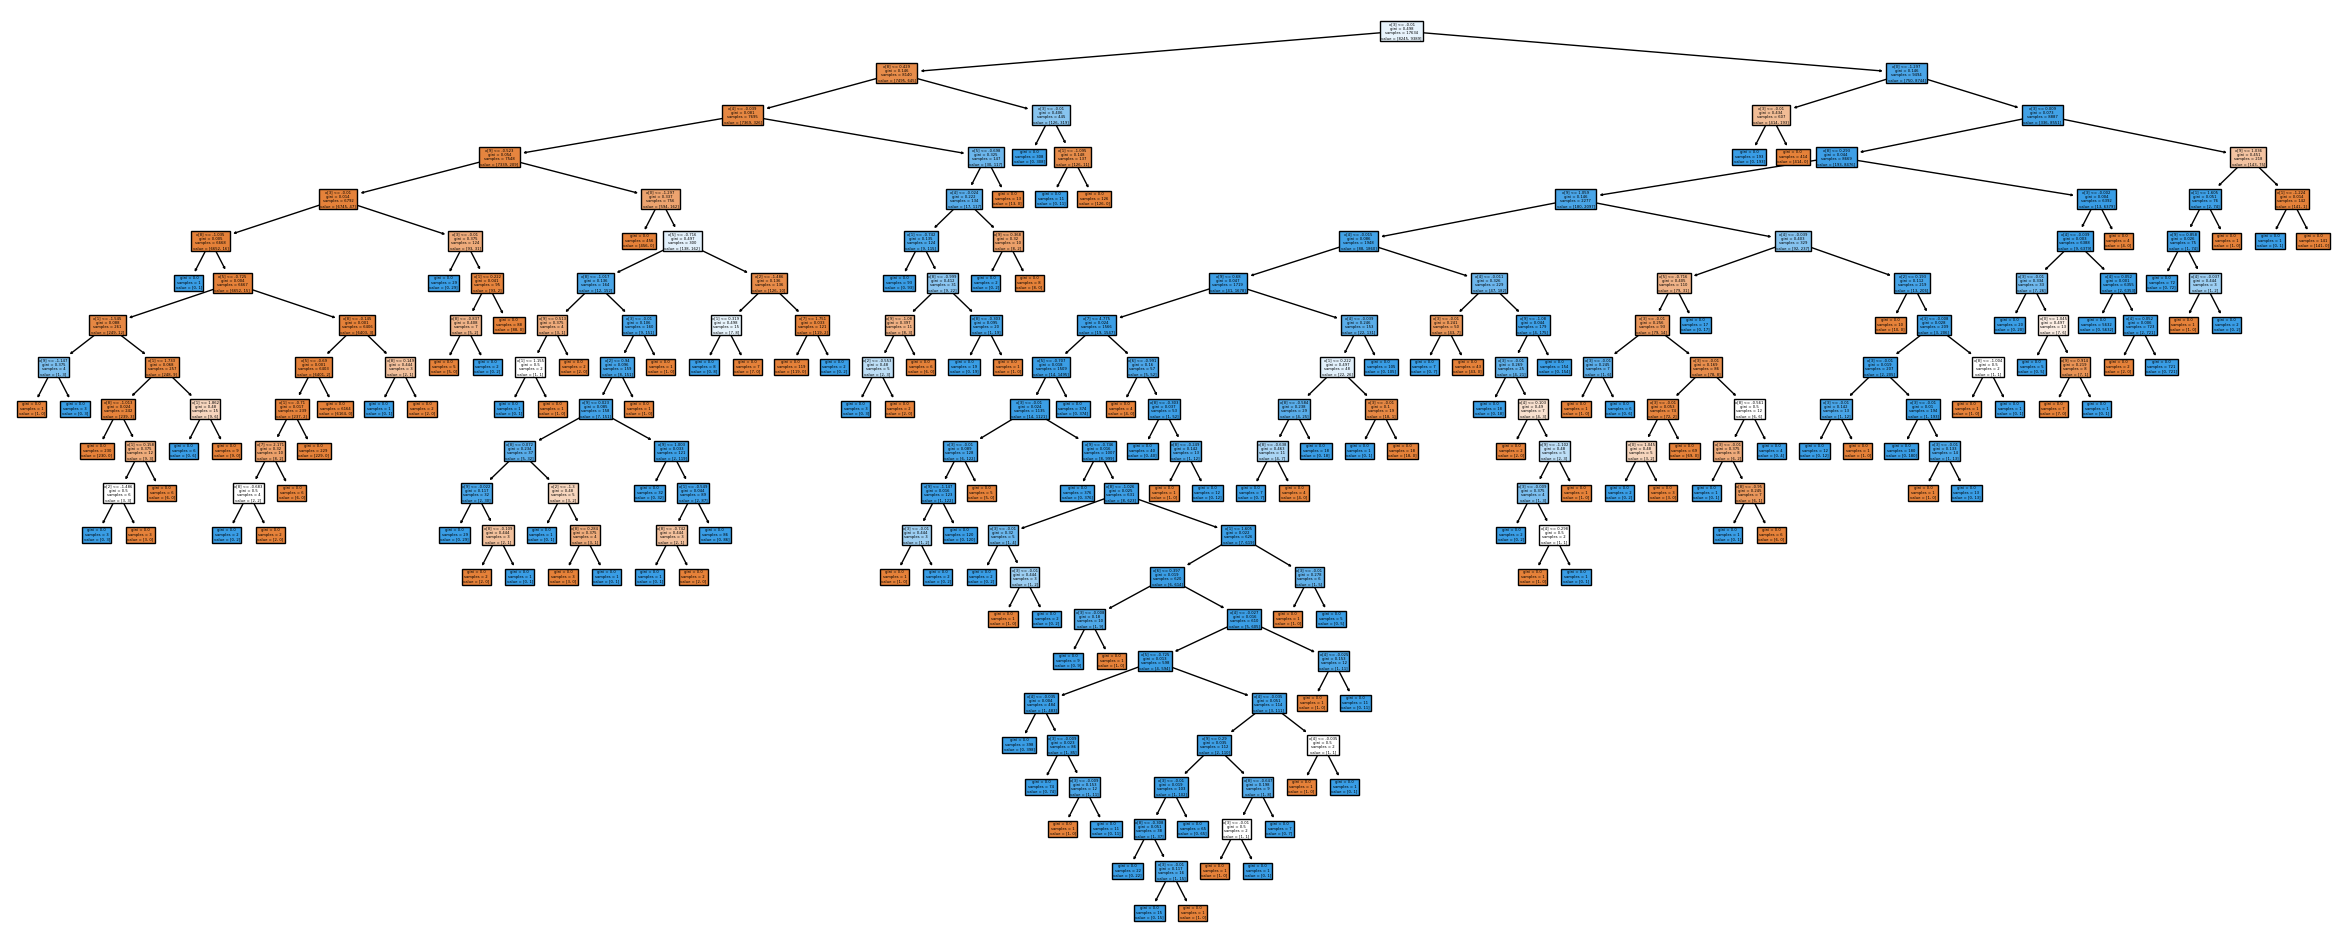

In [138]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(rf_dt, filled=True);
plt.show()

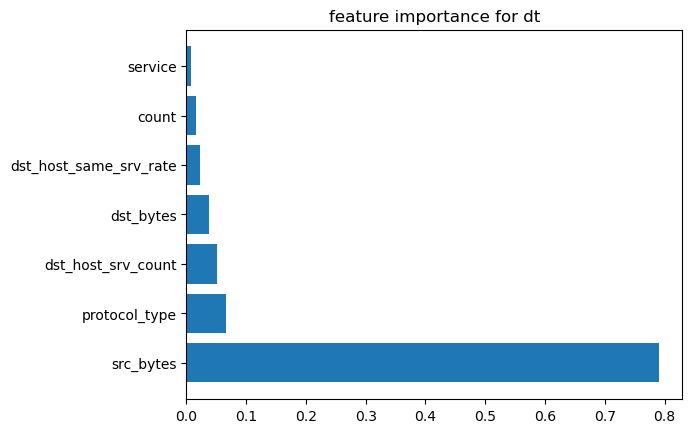

In [139]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = rf_selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importance(abs(rf_dt.feature_importances_), features_names, top=7)

# Random Forest Classifier

In [140]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [141]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=20, state=1, values=[0.9966922466260916], datetime_start=datetime.datetime(2023, 9, 11, 3, 12, 44, 296330), datetime_complete=datetime.datetime(2023, 9, 11, 3, 12, 45, 930554), params={'rf_max_depth': 18, 'rf_max_features': 5, 'rf_n_estimators': 18}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=20, value=None)


In [142]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 0.9998865827378927
Test Score: 0.9960306959513099


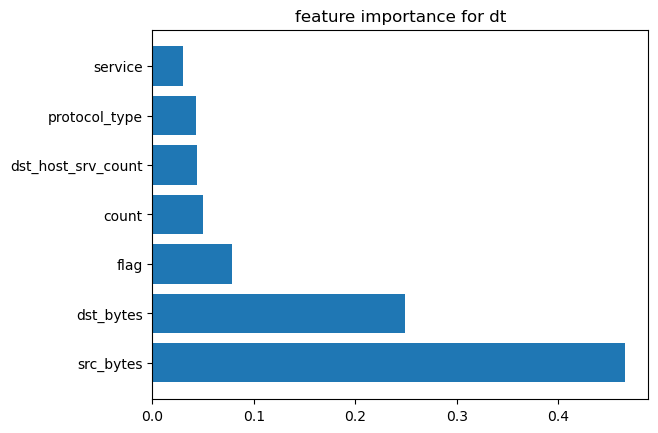

In [143]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importance(abs(rf.feature_importances_), features_names, top=7)

In [144]:
def rf_objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(rf_x_train, rf_y_train)
    accuracy = classifier_obj.score(rf_x_test, rf_y_test)
    return accuracy

In [145]:
rf_study_rf = optuna.create_study(direction='maximize')
rf_study_rf.optimize(rf_objective, n_trials=30)
print(rf_study_rf.best_trial)

FrozenTrial(number=14, state=1, values=[0.9962953162212226], datetime_start=datetime.datetime(2023, 9, 11, 3, 12, 58, 110437), datetime_complete=datetime.datetime(2023, 9, 11, 3, 12, 58, 529440), params={'rf_max_depth': 18, 'rf_max_features': 5, 'rf_n_estimators': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=14, value=None)


In [146]:
rf_rf = RandomForestClassifier(max_features = rf_study_rf.best_trial.params['rf_max_features'], max_depth = rf_study_rf.best_trial.params['rf_max_depth'], n_estimators = rf_study_rf.best_trial.params['rf_n_estimators'])
rf_rf.fit(rf_x_train, rf_y_train)

rf_rf_train, rf_rf_test = rf_rf.score(rf_x_train, rf_y_train), rf_rf.score(rf_x_test, rf_y_test)

print(f"Random Forest Train Score: {rf_rf_train}")
print(f"Random Forest Test Score: {rf_rf_test}")

Random Forest Train Score: 0.9999432913689463
Random Forest Test Score: 0.9957660756813972


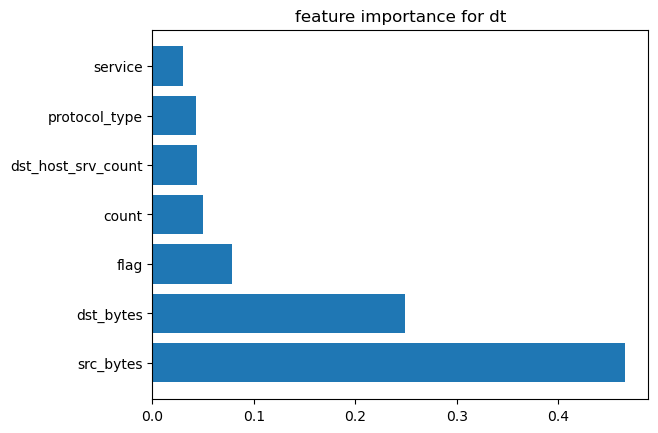

In [147]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = rf_selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importance(abs(rf.feature_importances_), features_names, top=7)

# SKLearn Gradient Boosting Model

In [148]:
SKGB = GradientBoostingClassifier(random_state=42)
SKGB.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [149]:
SKGB_train, SKGB_test = SKGB.score(x_train , y_train), SKGB.score(x_test , y_test)

print(f"Training Score: {SKGB_train}")
print(f"Test Score: {SKGB_test}")

Training Score: 0.9947828059430646
Test Score: 0.9927229425774015


In [150]:
rf_SKGB = GradientBoostingClassifier(random_state=42)
rf_SKGB.fit(rf_x_train, rf_y_train)

GradientBoostingClassifier(random_state=42)

In [151]:
rf_SKGB_train, rf_SKGB_test = rf_SKGB.score(rf_x_train , rf_y_train), rf_SKGB.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_SKGB_train}")
print(f"Random Forest Test Score: {rf_SKGB_test}")

Random Forest Training Score: 0.9947828059430646
Random Forest Test Score: 0.9927229425774015


# XGBoost Gradient Boosting Model

In [152]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [153]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 1.0
Test Score: 0.9962953162212226


In [154]:
rf_xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
rf_xgb_model.fit(rf_x_train, rf_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [155]:
rf_xgb_train, rf_xgb_test = rf_xgb_model.score(rf_x_train , rf_y_train), rf_xgb_model.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_xgb_train}")
print(f"Random Forest Test Score: {rf_xgb_test}")

Random Forest Training Score: 1.0
Random Forest Test Score: 0.9962953162212226


# Light Gradient Boosting Model

In [156]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [157]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 1.0
Test Score: 0.9965599364911352


In [158]:
rf_lgb_model = LGBMClassifier(random_state=42)
rf_lgb_model.fit(rf_x_train, rf_y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [159]:
rf_lgb_train, rf_lgb_test = rf_lgb_model.score(rf_x_train , rf_y_train), rf_lgb_model.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_lgb_train}")
print(f"Random Forest Test Score: {rf_lgb_test}")

Random Forest Training Score: 1.0
Random Forest Test Score: 0.9965599364911352


# SKLearn AdaBoost Model

In [160]:
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(x_train, y_train)

AdaBoostClassifier(random_state=42)

In [161]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.9800385618691165
Test Score: 0.9790949986768986


In [162]:
rf_ab_model = AdaBoostClassifier(random_state=42)
rf_ab_model.fit(rf_x_train, rf_y_train)

AdaBoostClassifier(random_state=42)

In [163]:
rf_ab_train, rf_ab_test = rf_ab_model.score(rf_x_train , rf_y_train), rf_ab_model.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_ab_train}")
print(f"Random Forest Test Score: {rf_ab_test}")

Random Forest Training Score: 0.9800385618691165
Random Forest Test Score: 0.9790949986768986


# CatBoost Classifier Model

In [164]:
cb_model = CatBoostClassifier(verbose=0)
cb_model.fit(x_train, y_train)

In [165]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9985822842236588
Test Score: 0.9956337655464409


In [166]:
rf_cb_model = CatBoostClassifier(verbose=0)
rf_cb_model.fit(rf_x_train, rf_y_train)

In [167]:
rf_cb_train, rf_cb_test = rf_cb_model.score(rf_x_train , rf_y_train), rf_cb_model.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_cb_train}")
print(f"Random Forest Test Score: {rf_cb_test}")

Random Forest Training Score: 0.9985822842236588
Random Forest Test Score: 0.9956337655464409


# Naive Baye Model

In [168]:
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)

BernoulliNB()

In [169]:
BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8975842123171147
Test Score: 0.8970627150039693


In [170]:
rf_BNB_model = BernoulliNB()
rf_BNB_model.fit(rf_x_train, rf_y_train)

BernoulliNB()

In [171]:
rf_BNB_train, rf_BNB_test = rf_BNB_model.score(rf_x_train , rf_y_train), rf_BNB_model.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_BNB_train}")
print(f"Random Forest Test Score: {rf_BNB_test}")

Random Forest Training Score: 0.8975842123171147
Random Forest Test Score: 0.8970627150039693


# Voting Model 

In [172]:
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")

In [173]:
v_clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=15)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_p...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x000002E3010CCF50>)])

In [174]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 1.0
Test Score: 0.9964276263561789


In [175]:
rf_v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', rf_KNN_model), ("XGBClassifier", rf_xgb_model), ("RandomForestClassifier", rf_rf), ("DecisionTree", rf_dt), ("XGBoost", rf_xgb_model), ("LightGB", rf_lgb_model), ("AdaBoost", rf_ab_model), ("Catboost", rf_cb_model)], voting = "hard")

In [176]:
rf_v_clf.fit(rf_x_train, rf_y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=16)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_p...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x000002E3011D6D50>)])

In [177]:
rf_voting_train, rf_voting_test = rf_v_clf.score(rf_x_train , rf_y_train), rf_v_clf.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_voting_train}")
print(f"Random Forest Test Score: {rf_voting_test}")

Random Forest Training Score: 1.0
Random Forest Test Score: 0.9958983858163535


# Bagging classifier

In [178]:
baggin = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
baggin.fit(x_train , y_train)
bag_train, bag_test = baggin.score(x_train , y_train), baggin.score(x_test , y_test)

print(f"Training Score: {bag_train}")
print(f"Test Score: {bag_test}")

Training Score: 0.9682998752410117
Test Score: 0.9711563905795184


In [179]:
rf_baggin = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
rf_baggin.fit(rf_x_train , rf_y_train)
rf_bag_train, rf_bag_test = rf_baggin.score(rf_x_train , rf_y_train), rf_baggin.score(rf_x_test , rf_y_test)

print(f"Random Forest Training Score: {rf_bag_train}")
print(f"Random Forest Test Score: {rf_bag_test}")

Random Forest Training Score: 0.9682998752410117
Random Forest Test Score: 0.9711563905795184


In [180]:
data = [["*KNN", f"{KNN_train*100:.2f}%", f"{KNN_test*100:.2f}%", f"            {rf_KNN_train*100:.2f}%", f"{rf_KNN_test*100:.2f}%"], 
        ["*Logistic Regression", f"{lg_train*100:.2f}%", f"{lg_test*100:.2f}%", f"{rf_lg_train*100:.2f}%", f"{rf_lg_test*100:.2f}%"],
        ["Decision Tree", f"{dt_train*100:.2f}%", f"{dt_test*100:.2f}%", f"{rf_dt_train*100:.2f}%", f"{rf_dt_test*100:.2f}%"], 
        ["Random Forest", f"{rf_train*100:.2f}%", f"{rf_test*100:.2f}%", f"{rf_rf_train*100:.2f}%", f"{rf_rf_test*100:.2f}%"], 
        ["GBM", f"{SKGB_train*100:.2f}%", f"{SKGB_test*100:.2f}%", f"{rf_SKGB_train*100:.2f}%", f"{rf_SKGB_test*100:.2f}%"], 
        ["XGBM", f"{xgb_train*100:.2f}%", f"{xgb_test*100:.2f}%", f"{rf_xgb_train*100:.2f}%", f"{rf_xgb_test*100:.2f}%"], 
        ["*Adaboost", f"{ab_train*100:.2f}%", f"{ab_test*100:.2f}%", f"{rf_ab_train*100:.2f}%", f"{rf_ab_test*100:.2f}%"], 
        ["light GBM", f"{lgb_train*100:.2f}%", f"{lgb_test*100:.2f}%", f"{rf_lgb_train*100:.2f}%", f"{rf_lgb_test*100:.2f}%"],
        ["CatBoost", f"{cb_train*100:.2f}%", f"{cb_test*100:.2f}%", f"{rf_cb_train*100:.2f}%", f"{rf_cb_test*100:.2f}%"], 
        ["*Naive Baye Model", f"{BNB_train*100:.2f}%", f"{BNB_test*100:.2f}%", f"{rf_BNB_train*100:.2f}%", f"{rf_BNB_test*100:.2f}%"], 
        ["*Voting", f"{voting_train*100:.2f}%", f"{voting_test*100:.2f}%", f"{rf_voting_train*100:.2f}%", f"{rf_voting_test*100:.2f}%"],
        ["*Baggings", f"{bag_train*100:.2f}%", f"{bag_test*100:.2f}%", f"{rf_bag_train*100:.2f}%", f"{rf_bag_test*100:.2f}%"]]

col_names = ["Model", "RreliefF Train Score", "RreliefF Test Score", "Random Forest Train Score", "Random Forest Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
print('SVM Model takes a bit of time to run')
print('please wait while it runs')

╒══════════════════════╤════════════════════════╤═══════════════════════╤═════════════════════════════╤════════════════════════════╕
│ Model                │ RreliefF Train Score   │ RreliefF Test Score   │ Random Forest Train Score   │ Random Forest Test Score   │
╞══════════════════════╪════════════════════════╪═══════════════════════╪═════════════════════════════╪════════════════════════════╡
│ *KNN                 │ 98.07%                 │ 97.98%                │ 97.99%                      │ 97.91%                     │
├──────────────────────┼────────────────────────┼───────────────────────┼─────────────────────────────┼────────────────────────────┤
│ *Logistic Regression │ 92.88%                 │ 92.31%                │ 92.88%                      │ 92.31%                     │
├──────────────────────┼────────────────────────┼───────────────────────┼─────────────────────────────┼────────────────────────────┤
│ Decision Tree        │ 99.89%                 │ 99.34%             

# SVM Model

In [181]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [182]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=3)
print(study_svm.best_trial)

FrozenTrial(number=2, state=1, values=[0.9322572109023551], datetime_start=datetime.datetime(2023, 9, 11, 3, 16, 23, 350529), datetime_complete=datetime.datetime(2023, 9, 11, 3, 16, 30, 435199), params={'kernel': 'linear', 'c': 0.68}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=2, value=None)


In [183]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)

SVC(C=0.68, kernel='linear')

In [184]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)


print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.9355789951230578
Test Score: 0.9322572109023551


In [185]:
def rf_objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(rf_x_train, rf_y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(rf_x_train, rf_y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(rf_x_train, rf_y_train)
        
    accuracy = classifier_obj.score(rf_x_test, rf_y_test)
    return accuracy

In [186]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(rf_objective, n_trials=3)
print(study_svm.best_trial)

FrozenTrial(number=2, state=1, values=[0.9707594601746494], datetime_start=datetime.datetime(2023, 9, 11, 3, 16, 47, 630971), datetime_complete=datetime.datetime(2023, 9, 11, 3, 16, 52, 124867), params={'kernel': 'rbf', 'c': 0.9400000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=2, value=None)


In [187]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    rf_SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    rf_SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    rf_SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

rf_SVM_model.fit(rf_x_train, rf_y_train)

SVC(C=0.9400000000000001)

In [188]:
rf_SVM_train, rf_SVM_test = rf_SVM_model.score(rf_x_train , rf_y_train), rf_SVM_model.score(rf_x_test , rf_y_test)


print(f"Random Forest Training Score: {rf_SVM_train}")
print(f"Random Forest Test Score: {rf_SVM_test}")

Random Forest Training Score: 0.9681864579789043
Random Forest Test Score: 0.9707594601746494


# Summary

In [189]:
data.append(["*SVM", f"{SVM_train*100:.2f}%", f"{SVM_test*100:.2f}%", f"{rf_SVM_train*100:.2f}%", f"{rf_SVM_test*100:.2f}%"])

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒══════════════════════╤════════════════════════╤═══════════════════════╤═════════════════════════════╤════════════════════════════╕
│ Model                │ RreliefF Train Score   │ RreliefF Test Score   │ Random Forest Train Score   │ Random Forest Test Score   │
╞══════════════════════╪════════════════════════╪═══════════════════════╪═════════════════════════════╪════════════════════════════╡
│ *KNN                 │ 98.07%                 │ 97.98%                │ 97.99%                      │ 97.91%                     │
├──────────────────────┼────────────────────────┼───────────────────────┼─────────────────────────────┼────────────────────────────┤
│ *Logistic Regression │ 92.88%                 │ 92.31%                │ 92.88%                      │ 92.31%                     │
├──────────────────────┼────────────────────────┼───────────────────────┼─────────────────────────────┼────────────────────────────┤
│ Decision Tree        │ 99.89%                 │ 99.34%             